In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

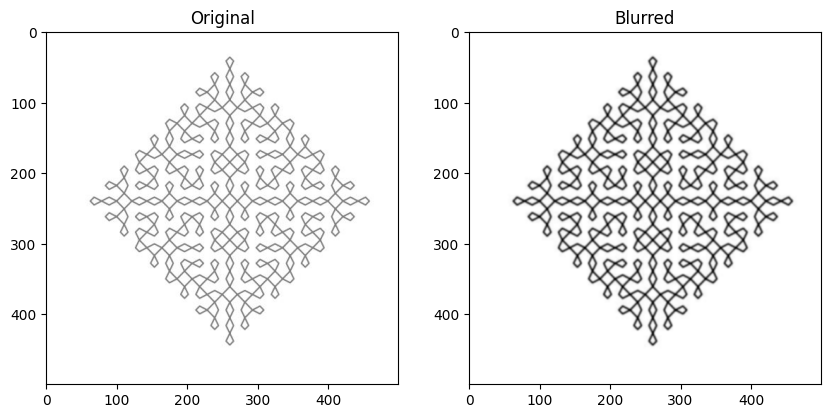

In [4]:
# Load image
img = cv2.imread("/Users/aryanmanchanda/Projects/Kolam/data/Kolam copy/kolam19-0.jpg")

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Reduce noise
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Show original & blurred
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(blur, cmap="gray"); plt.title("Blurred")
plt.show()

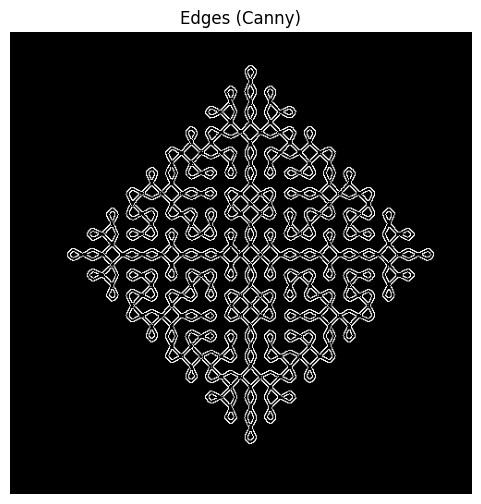

In [5]:
# Apply Canny edge detection
edges = cv2.Canny(blur, 50, 150)

plt.figure(figsize=(6,6))
plt.imshow(edges, cmap="gray")
plt.title("Edges (Canny)")
plt.axis("off")
plt.show()

Number of loops/contours detected: 1


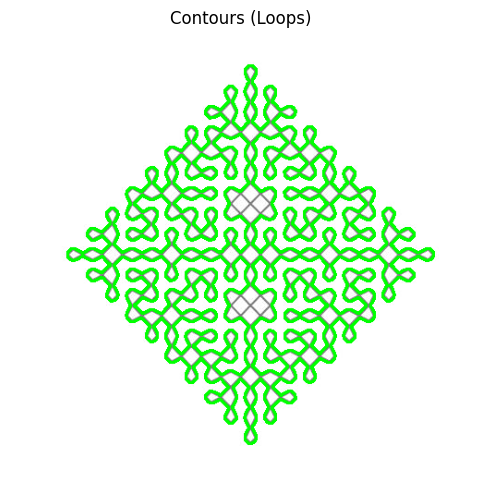

In [6]:
# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on a copy
contour_img = img.copy()
cv2.drawContours(contour_img, contours, -1, (0,255,0), 2)

print("Number of loops/contours detected:", len(contours))

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.title("Contours (Loops)")
plt.axis("off")
plt.show()

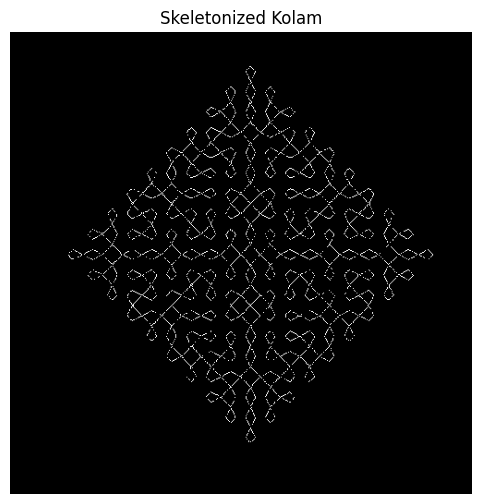

In [7]:
# Threshold for binary mask
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# Skeletonize (convert to boolean first)
skeleton = skeletonize(binary // 255)

plt.figure(figsize=(6,6))
plt.imshow(skeleton, cmap="gray")
plt.title("Skeletonized Kolam")
plt.axis("off")
plt.show()

Vertical symmetry score: 0.904


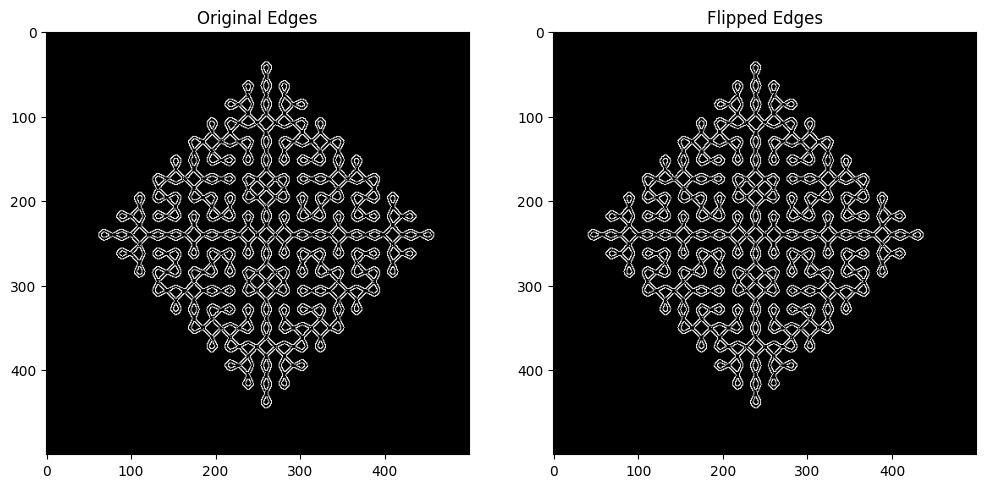

In [8]:
# Vertical flip comparison
flipped = cv2.flip(edges, 1)  # flip along vertical axis
symmetry_score = np.sum(edges == flipped) / edges.size

print("Vertical symmetry score:", round(symmetry_score, 3))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(edges, cmap="gray"); plt.title("Original Edges")
plt.subplot(1,2,2); plt.imshow(flipped, cmap="gray"); plt.title("Flipped Edges")
plt.show()

Dots detected: 0


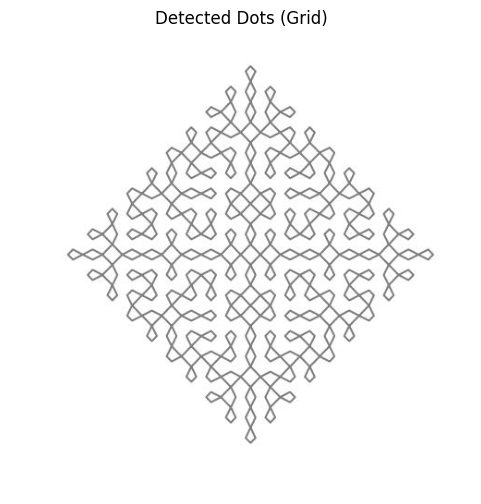

In [9]:
# Detect circles (possible dot grid) using Hough Transform
circles = cv2.HoughCircles(
    gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
    param1=50, param2=30, minRadius=3, maxRadius=10
)

dot_img = img.copy()
if circles is not None:
    circles = np.uint16(np.around(circles))
    for (x,y,r) in circles[0,:]:
        cv2.circle(dot_img, (x,y), r, (255,0,0), 2)

print("Dots detected:", 0 if circles is None else circles.shape[1])

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(dot_img, cv2.COLOR_BGR2RGB))
plt.title("Detected Dots (Grid)")
plt.axis("off")
plt.show()

In [10]:
def analyze_kolam(image_path, show_steps=True):
    """
    Analyze Kolam image for contours, skeleton, symmetry (vertical + rotational),
    dot detection, and classify the kolam type.
    """
    results = {}

    # 1. Load & Preprocess
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)

    # 2. Edge Detection
    edges = cv2.Canny(blur, 50, 150)

    # 3. Contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    results["num_loops"] = len(contours)

    # 4. Skeletonization
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    skeleton = skeletonize(binary // 255)
    results["skeleton_pixels"] = int(np.sum(skeleton))

    # 5. Symmetry checks
    flipped = cv2.flip(edges, 1)
    vertical_sym = np.sum(edges == flipped) / edges.size
    results["vertical_symmetry"] = round(vertical_sym, 3)

    def rotation_symmetry(edge_img, angle):
        h, w = edge_img.shape
        center = (w//2, h//2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(edge_img, M, (w,h), flags=cv2.INTER_NEAREST)
        return np.sum(edge_img == rotated) / edge_img.size

    results["rot90_symmetry"]  = round(rotation_symmetry(edges, 90), 3)
    results["rot180_symmetry"] = round(rotation_symmetry(edges, 180), 3)
    results["rot270_symmetry"] = round(rotation_symmetry(edges, 270), 3)

    # 6. Dot detection
    circles = cv2.HoughCircles(
        gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
        param1=50, param2=30, minRadius=3, maxRadius=10
    )
    results["num_dots"] = 0 if circles is None else circles.shape[1]

    # 7. Complexity score
    results["complexity_score"] = (
        results["num_loops"] * 2
        + results["num_dots"] * 1.5
        + (1 if results["vertical_symmetry"] > 0.7 else 0)
        + (1 if results["rot180_symmetry"] > 0.7 else 0)
    )

    # 8. Kolam type classification
    if results["num_dots"] > 5:
        results["kolam_type"] = "Pulli Kolam (Dot-based)"
    elif results["num_dots"] <= 2 and results["num_loops"] <= 2:
        results["kolam_type"] = "Sikku Kolam (Continuous loop)"
    else:
        results["kolam_type"] = "Freehand Kolam (Artistic)"

    # Visualization (optional)
    if show_steps:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original")
        plt.subplot(1,3,2); plt.imshow(edges, cmap="gray"); plt.title("Edges")
        plt.subplot(1,3,3); plt.imshow(skeleton, cmap="gray"); plt.title("Skeleton")
        plt.show()

    return results

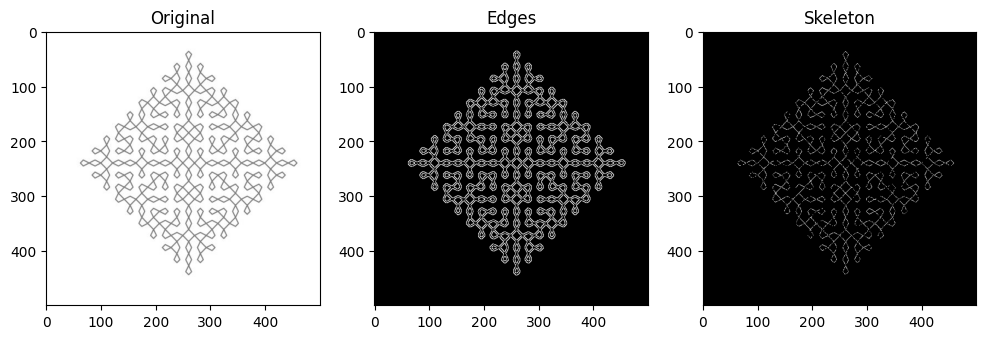

Kolam Analysis Results:
num_loops: 1
skeleton_pixels: 4724
vertical_symmetry: 0.904
rot90_symmetry: 0.893
rot180_symmetry: 0.891
rot270_symmetry: 0.893
num_dots: 0
complexity_score: 4.0
kolam_type: Sikku Kolam (Continuous loop)


In [11]:
results = analyze_kolam("/Users/aryanmanchanda/Projects/Kolam/data/Kolam copy/kolam19-0.jpg", show_steps=True)
print("Kolam Analysis Results:")
for k,v in results.items():
    print(f"{k}: {v}")

In [12]:
import networkx as nx
from skimage.morphology import skeletonize
from skimage.util import invert
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [13]:
from skimage.morphology import thin
from scipy.ndimage import convolve

def skeleton_to_graph(skeleton):
    """
    Convert a skeleton (binary image) to a graph:
    - Nodes: endpoints and junctions
    - Edges: paths connecting nodes
    """
    G = nx.Graph()
    skel = skeleton.astype(np.uint8)
    
    # Define 3x3 kernel to count neighbors
    kernel = np.array([[1,1,1],
                       [1,10,1],
                       [1,1,1]])
    
    neighbor_count = convolve(skel, np.ones((3,3)), mode='constant', cval=0) * skel
    
    # Find nodes: endpoints (1 neighbor) and junctions (>2 neighbors)
    nodes = []
    for y in range(1, skel.shape[0]-1):
        for x in range(1, skel.shape[1]-1):
            if skel[y,x]:
                n = np.sum(skel[y-1:y+2, x-1:x+2]) - 1
                if n == 1 or n > 2:
                    nodes.append((x,y))
                    G.add_node((x,y))
    
    # Simple edge building: connect nodes along skeleton paths
    # For simplicity, connect nearby nodes within 1-pixel radius
    for i, n1 in enumerate(nodes):
        for n2 in nodes[i+1:]:
            if np.linalg.norm(np.array(n1)-np.array(n2)) < 10:  # adjustable threshold
                G.add_edge(n1, n2)
    
    return G

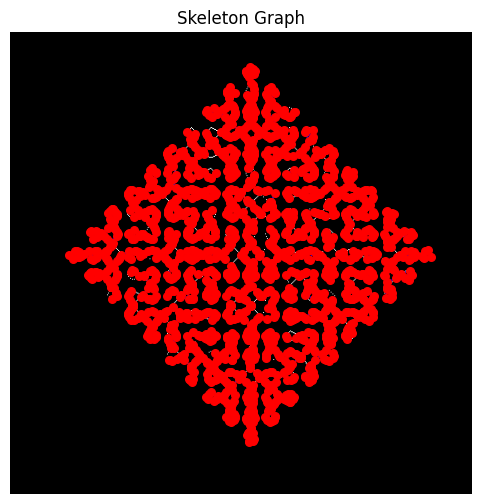

In [14]:
# Load & skeletonize example
img = cv2.imread("/Users/aryanmanchanda/Projects/Kolam/data/Kolam copy/kolam19-0.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
skeleton = skeletonize(binary // 255)

# Convert skeleton to graph
G = skeleton_to_graph(skeleton)

# Plot graph on top of skeleton
plt.figure(figsize=(6,6))
plt.imshow(skeleton, cmap="gray")
pos = {n: (n[0], n[1]) for n in G.nodes()}
nx.draw(G, pos=pos, node_color='red', node_size=30, edge_color='blue')
plt.title("Skeleton Graph")
plt.axis("off")
plt.show()

In [15]:
print("Number of nodes (junctions/endpoints):", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# Check if graph is connected
print("Is skeleton graph connected?", nx.is_connected(G))

# Optional: Eulerian path/circuit check
print("Has Eulerian circuit?", nx.is_eulerian(G))

Number of nodes (junctions/endpoints): 1913
Number of edges: 7345
Is skeleton graph connected? False
Has Eulerian circuit? False


# Analyze and Create

In [16]:
import numpy as np
from skimage.morphology import skeletonize
from skimage.measure import label

def get_skeleton_paths(image_path):
    """
    Returns a list of ordered point sequences along skeleton loops
    """
    import cv2
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    skeleton = skeletonize(binary // 255)

    # Label connected components
    labeled = label(skeleton)
    paths = []

    for region_id in range(1, labeled.max()+1):
        coords = np.column_stack(np.where(labeled==region_id))
        # Sort coordinates to form a path (simple nearest neighbor sorting)
        path = [coords[0]]
        remaining = set(map(tuple, coords[1:]))
        while remaining:
            last = path[-1]
            nearest = min(remaining, key=lambda p: np.linalg.norm(np.array(p)-np.array(last)))
            path.append(nearest)
            remaining.remove(nearest)
        paths.append(path)

    return paths

In [17]:
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

def generate_sikku_from_skeleton(paths, num_points=200):
    """
    Generate smooth Sikku Kolam curves following skeleton paths
    """
    plt.figure(figsize=(6,6))
    for path in paths:
        x = np.array([pt[1] for pt in path])  # note: (row,col) -> (y,x)
        y = np.array([pt[0] for pt in path])

        if len(x) < 3:  # need at least 3 points for spline
            continue

        tck, u = splprep([x, y], s=1)  # small smoothing
        u_new = np.linspace(0,1,num_points)
        x_new, y_new = splev(u_new, tck)
        plt.plot(x_new, y_new, color='blue', linewidth=1.5)

    plt.axis('equal')
    plt.axis('off')
    plt.show()

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Arc
from skimage.morphology import skeletonize
from scipy.interpolate import splprep, splev

# --- Analysis Function ---
def analyze_kolam(image_path):
    """
    Analyze Kolam image to extract structural parameters
    """
    results = {}
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    
    # Edge & loops
    edges = cv2.Canny(blur, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    results["num_loops"] = len(contours)

    # Skeleton
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    skeleton = skeletonize(binary // 255)
    results["skeleton_pixels"] = int(np.sum(skeleton))

    # Symmetry
    flipped = cv2.flip(edges, 1)
    results["vertical_symmetry"] = round(np.sum(edges==flipped)/edges.size, 3)

    # Dot detection
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                               param1=50, param2=30, minRadius=3, maxRadius=10)
    results["num_dots"] = 0 if circles is None else circles.shape[1]
    results["circles"] = circles

    # Kolam type
    if results["num_dots"] > 5:
        results["kolam_type"] = "Pulli"
    else:
        results["kolam_type"] = "Sikku"

    return results

# --- Pulli Kolam Generator ---
def generate_pullikolam(num_dots=5, spacing=1.0, symmetry=2, loop_count=3):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal')
    ax.axis('off')

    # Place dots
    dot_positions = []
    for i in range(num_dots):
        for j in range(num_dots):
            x, y = i*spacing, j*spacing
            dot_positions.append((x,y))
            ax.add_patch(Circle((x, y), 0.05, color='black'))

    # Draw loops/arcs
    for loop in range(loop_count):
        for (x,y) in dot_positions[::2]:
            for s in range(symmetry):
                angle = s * (360/symmetry)
                ax.add_patch(Arc(
                    (x,y), width=0.8, height=0.8, angle=angle,
                    theta1=0, theta2=180, color='red', linewidth=1.5
                ))

    plt.show()

# --- Sikku Kolam Generator (Spline-based) ---
def generate_sikku_from_skeleton(paths, num_points=200):
    import matplotlib.pyplot as plt
    from scipy.interpolate import splprep, splev

    plt.figure(figsize=(6,6))
    for path in paths:
        if len(path) < 3:
            continue

        k = min(3, len(path)-1)  # cubic, quadratic, or linear
        x = np.array([pt[1] for pt in path])
        y = np.array([pt[0] for pt in path])

        tck, u = splprep([x, y], s=1, k=k)
        u_new = np.linspace(0,1,num_points)
        x_new, y_new = splev(u_new, tck)
        plt.plot(x_new, y_new, color='blue', linewidth=1.5)

    plt.axis('equal')
    plt.axis('off')
    plt.show()


import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Circle
from scipy.interpolate import splprep, splev
import numpy as np

def generate_sikku_from_dots(dot_positions, loops=2, symmetry=4, num_points=200):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal')
    ax.axis('off')

    # Draw dots
    for (x,y) in dot_positions:
        ax.add_patch(Circle((x,y), 0.05, color='black'))

    # Generate smooth curves
    for loop in range(loops):
        # Randomly shuffle dots to create flowing path
        path = dot_positions.copy()
        np.random.shuffle(path)
        x = np.array([pt[0] for pt in path])
        y = np.array([pt[1] for pt in path])
        tck, u = splprep([x, y], s=1.0, k=min(3,len(x)-1))
        u_new = np.linspace(0,1,num_points)
        x_new, y_new = splev(u_new, tck)
        ax.plot(x_new, y_new, color='blue', linewidth=1.5)

        # Apply symmetry rotations
        for s in range(1,symmetry):
            angle = s*(360/symmetry)
            theta = np.deg2rad(angle)
            x_rot = np.cos(theta)*x_new - np.sin(theta)*y_new
            y_rot = np.sin(theta)*x_new + np.cos(theta)*y_new
            ax.plot(x_rot, y_rot, color='blue', linewidth=1.5)

    plt.show()

# --- End-to-End Function ---
def analyze_and_generate_kolam_perfect(image_path):
    results = analyze_kolam(image_path)
    print("Kolam Analysis Features:")
    for k,v in results.items():
        if k != "circles":
            print(f"{k}: {v}")

    if results["kolam_type"] == "Pulli":
        print("Generating Pulli Kolam...")
        generate_pullikolam(
            num_dots=int(np.sqrt(results["num_dots"])),
            spacing=1.0,
            symmetry=2,
            loop_count=max(1, results["num_loops"])
        )
    else:
        print("Generating Sikku Kolam (following skeleton)...")
        paths = get_skeleton_paths(image_path)
        generate_sikku_from_skeleton(paths)

    return results

Kolam Analysis Features:
num_loops: 1
skeleton_pixels: 4724
vertical_symmetry: 0.904
num_dots: 0
kolam_type: Sikku
Generating Sikku Kolam (following skeleton)...


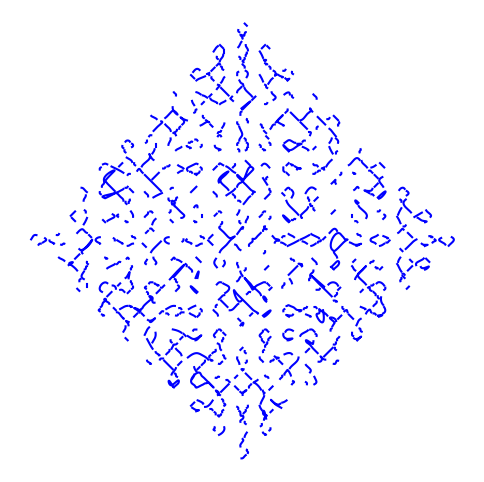

In [19]:
results = analyze_and_generate_kolam_perfect("/Users/aryanmanchanda/Projects/Kolam/data/Kolam copy/kolam19-0.jpg")

# Attempt 2

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

def analyze_and_plot_kolam(image_path, dot_size=5, skeleton_marker_size=1, skeleton_color='gray'):
    """
    Analyze a Kolam image and plot the dots and skeleton.

    Parameters:
    - image_path: str, path to the Kolam image
    - dot_size: int, size of the dots in the output plot
    - skeleton_marker_size: int, size of skeleton points in the output plot
    - skeleton_color: str or color, color for the skeleton points
    """
    
    # 1. Load image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 2. Threshold (invert if necessary)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    
    # 3. Skeletonize
    skeleton = skeletonize(binary // 255)
    
    # 4. Detect dots (lenient settings)
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = 2
    params.maxArea = 1000
    params.filterByCircularity = False
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(binary)
    dots = [kp.pt for kp in keypoints]
    
    # 5. Plotting
    fig, ax = plt.subplots(figsize=(8,8))
    
    # Plot dots
    for x, y in dots:
        ax.plot(x, y, 'ko', markersize=dot_size)
    
    # Plot skeleton pixels as separate points in grey
    coords = np.column_stack(np.where(skeleton))
    ax.plot(coords[:,1], coords[:,0], '.', color=skeleton_color, markersize=skeleton_marker_size)
    
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.axis('off')
    plt.show()
    
    return dots, skeleton

# Example usage:
# dots, skeleton = analyze_and_plot_kolam("/Users/aryanmanchanda/Projects/Kolam/data/Kolam copy/kolam19-0.jpg")

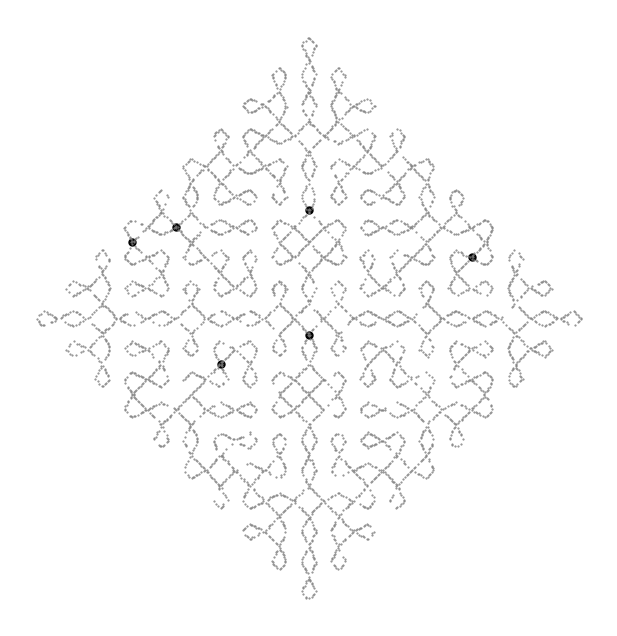

In [21]:
dots, skeleton = analyze_and_plot_kolam("/Users/aryanmanchanda/Projects/Kolam/data/Kolam copy/kolam19-0.jpg")

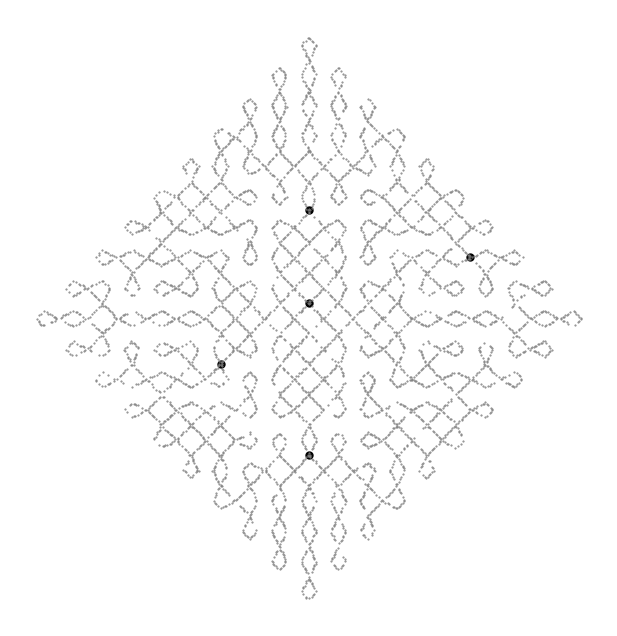

In [22]:
dots, skeleton = analyze_and_plot_kolam("/Users/aryanmanchanda/Projects/Kolam/data/Kolam copy/kolam19-20.jpg")

In [28]:
img_path = "/Users/aryanmanchanda/Projects/Kolam/data/Kolam copy/kolam19-20.jpg"

In [29]:
def canny(img):
    img = cv2.imread(img)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)

    plt.figure(figsize=(6,6))
    plt.imshow(edges, cmap="gray")
    plt.title("Edges (Canny)")
    plt.axis("off")
    plt.show()

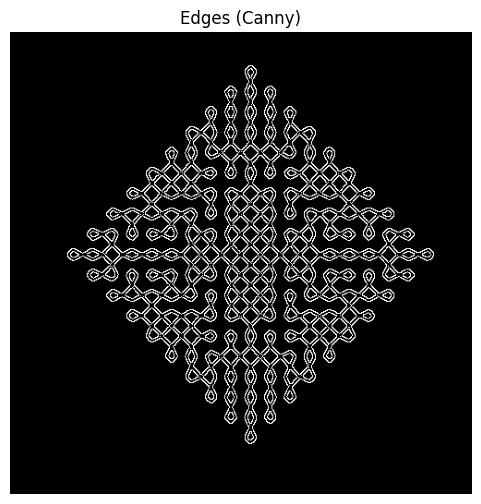

In [30]:
canny(img_path)

Number of loops/contours detected: 1


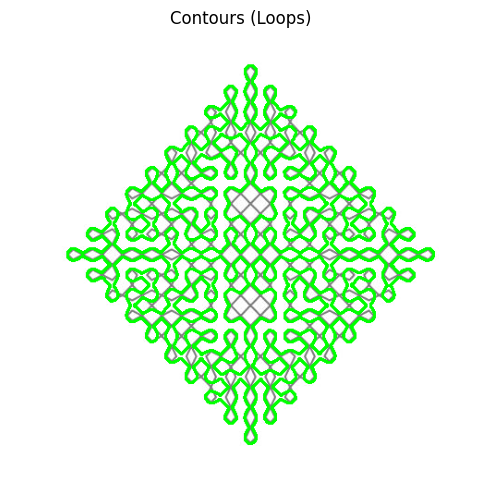

In [ ]:
def contours(img_path):
    img = cv2.imread(img_path)
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on a copy
    contour_img = img.copy()
    cv2.drawContours(contour_img, contours, -1, (0,255,0), 2)

    print("Number of loops/contours detected:", len(contours))

    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
    plt.title("Contours (Loops)")
    plt.axis("off")
    plt.show()

contours(img_path)

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

def analyze_kolam_full(image_path, dot_size=5, skeleton_marker_size=1, skeleton_color='gray'):
    """
    Full analysis of a Kolam image, displaying all major intermediate steps.
    
    Steps displayed:
    1. Grayscale
    2. Canny edges
    3. Contours
    4. Skeleton
    5. Detected dots on skeleton
    """
    # 1. Load image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    # 2. Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 3. Canny edge detection
    edges = cv2.Canny(gray, 50, 150)
    
    # 4. Find contours
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = np.zeros_like(gray)
    cv2.drawContours(contour_img, contours, -1, 255, 1)
    
    # 5. Threshold and skeletonize
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    skeleton = skeletonize(binary // 255)
    
    # 6. Detect dots
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = 2
    params.maxArea = 1000
    params.filterByCircularity = False
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(binary)
    dots = [kp.pt for kp in keypoints]
    
    # 7. Plot all intermediate results
    fig, axes = plt.subplots(2, 3, figsize=(15,10))
    
    # Original grayscale
    axes[0,0].imshow(gray, cmap='gray')
    axes[0,0].set_title("Grayscale")
    axes[0,0].axis('off')
    
    # Canny edges
    axes[0,1].imshow(edges, cmap='gray')
    axes[0,1].set_title("Canny Edges")
    axes[0,1].axis('off')
    
    # Contours
    axes[0,2].imshow(contour_img, cmap='gray')
    axes[0,2].set_title("Contours")
    axes[0,2].axis('off')
    
    # Skeleton
    axes[1,0].imshow(skeleton, cmap='gray')
    axes[1,0].set_title("Skeleton")
    axes[1,0].axis('off')
    
    # Dots
    axes[1,1].imshow(gray, cmap='gray')
    for x, y in dots:
        axes[1,1].plot(x, y, 'ro', markersize=dot_size)
    axes[1,1].set_title("Detected Dots")
    axes[1,1].axis('off')
    
    # Skeleton + Dots
    axes[1,2].imshow(gray, cmap='gray')
    coords = np.column_stack(np.where(skeleton))
    axes[1,2].plot(coords[:,1], coords[:,0], '.', color=skeleton_color, markersize=skeleton_marker_size)
    for x, y in dots:
        axes[1,2].plot(x, y, 'ko', markersize=dot_size)
    axes[1,2].set_title("Skeleton + Dots")
    axes[1,2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return gray, edges, contour_img, skeleton, dots

# Example usage:
# gray, edges, contours, skeleton, dots = analyze_kolam_full("/Users/aryanmanchanda/Projects/Kolam/data/Kolam copy/kolam19-0.jpg")

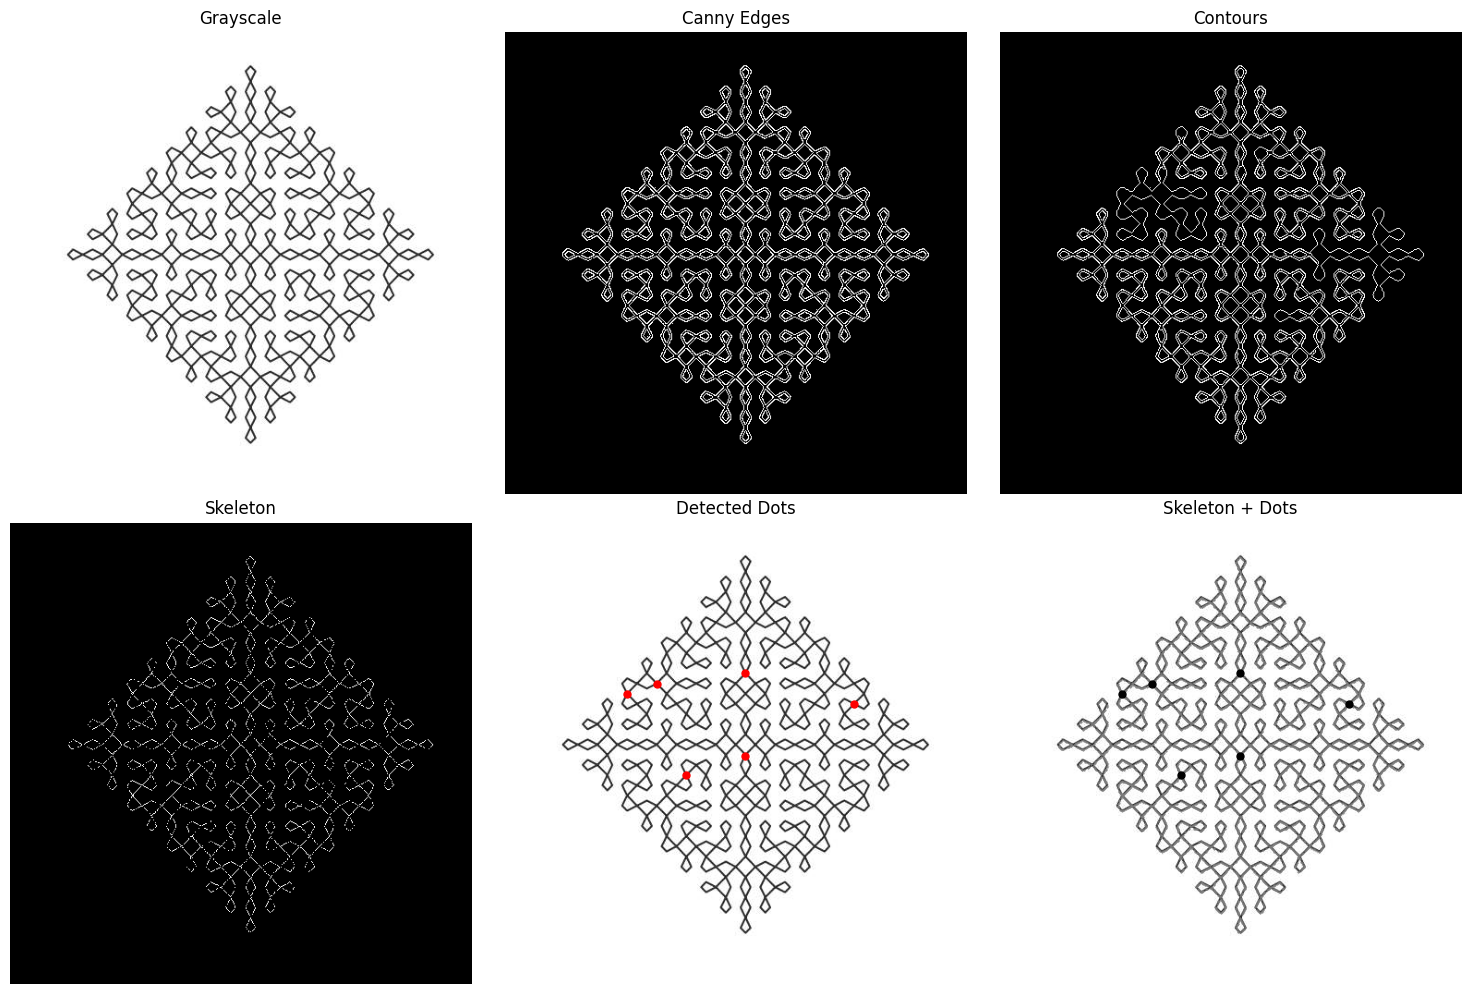

In [37]:
gray, edges, contours, skeleton, dots = analyze_kolam_full("/Users/aryanmanchanda/Projects/Kolam/data/Kolam copy/kolam19-0.jpg")

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from PIL import Image, ExifTags

def analyze_kolam_full_phone(image_path, dot_size=5, skeleton_marker_size=1, skeleton_color='gray', max_dim=1024):
    """
    Analyze a Kolam image from phone photos, displaying all intermediate steps:
    - Grayscale
    - Canny edges
    - Contours
    - Skeleton
    - Detected dots
    Handles phone orientation, adaptive thresholding, and resizing.
    """
    # 1. Load image with PIL (for EXIF orientation)
    img = Image.open(image_path)
    
    # 2. Correct orientation based on EXIF
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation]=='Orientation':
                break
        exif = img._getexif()
        if exif is not None:
            orientation_value = exif.get(orientation, None)
            if orientation_value == 3:
                img = img.rotate(180, expand=True)
            elif orientation_value == 6:
                img = img.rotate(270, expand=True)
            elif orientation_value == 8:
                img = img.rotate(90, expand=True)
    except:
        pass  # no EXIF orientation
    
    # 3. Convert to OpenCV format
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    
    # 4. Resize if too large
    h, w = image.shape[:2]
    if max(h, w) > max_dim:
        scale = max_dim / max(h, w)
        image = cv2.resize(image, (int(w*scale), int(h*scale)))
    
    # 5. Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 6. Canny edges
    edges = cv2.Canny(gray, 50, 150)
    
    # 7. Contours
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = np.zeros_like(gray)
    cv2.drawContours(contour_img, contours, -1, 255, 1)
    
    # 8. Adaptive thresholding and skeletonization
    binary = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=11,
        C=2
    )
    skeleton = skeletonize(binary // 255)
    
    # 9. Detect dots (lenient)
    params = cv2.SimpleBlobDetector_Params()
    params.filterByArea = True
    params.minArea = 2
    params.maxArea = 1000
    params.filterByCircularity = False
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(binary)
    dots = [kp.pt for kp in keypoints]
    
    # 10. Plot results
    fig, axes = plt.subplots(2, 3, figsize=(15,10))
    
    axes[0,0].imshow(gray, cmap='gray'); axes[0,0].set_title("Grayscale"); axes[0,0].axis('off')
    axes[0,1].imshow(edges, cmap='gray'); axes[0,1].set_title("Canny Edges"); axes[0,1].axis('off')
    axes[0,2].imshow(contour_img, cmap='gray'); axes[0,2].set_title("Contours"); axes[0,2].axis('off')
    axes[1,0].imshow(skeleton, cmap='gray'); axes[1,0].set_title("Skeleton"); axes[1,0].axis('off')
    
    axes[1,1].imshow(gray, cmap='gray')
    for x, y in dots:
        axes[1,1].plot(x, y, 'ro', markersize=dot_size)
    axes[1,1].set_title("Detected Dots"); axes[1,1].axis('off')
    
    axes[1,2].imshow(gray, cmap='gray')
    coords = np.column_stack(np.where(skeleton))
    axes[1,2].plot(coords[:,1], coords[:,0], '.', color=skeleton_color, markersize=skeleton_marker_size)
    for x, y in dots:
        axes[1,2].plot(x, y, 'ko', markersize=dot_size)
    axes[1,2].set_title("Skeleton + Dots"); axes[1,2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return gray, edges, contour_img, skeleton, dots

# Example usage:
# gray, edges, contours, skeleton, dots = analyze_kolam_full_phone("phone_photo.jpg")

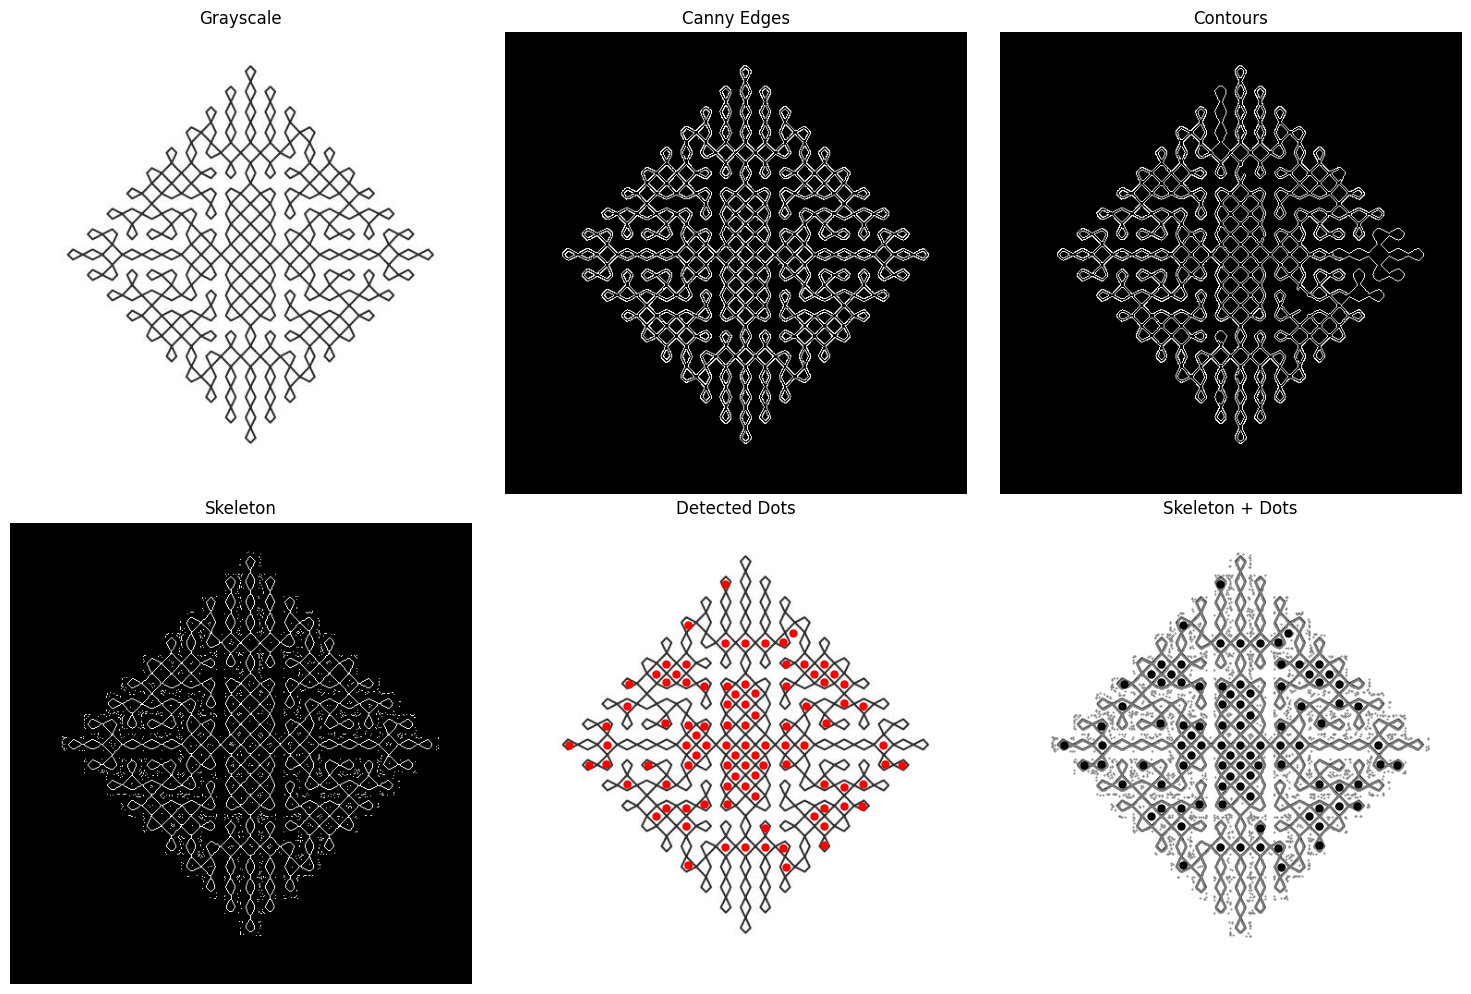

In [39]:
gray, edges, contours, skeleton, dots = analyze_kolam_full_phone(img_path)